<a href="https://colab.research.google.com/github/llai7/MATH227C/blob/main/Math227C20Sp_P11_LuluLai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Math 227C Problem Set 11: Markov Chain Monte Carlo!

In the first part of this notebook, we simulate a chemical reaction

$$\frac{dx}{dt} = k_{\rm on} - k_{\rm off} x$$

with some observational noise

$$y = x + \epsilon$$

where $\epsilon$ is Gaussian distributed with standard deviation $\sigma$.

Then we use MCMC to fit the simulated data to discover the values of paramaters ``kon``, ``koff`` and ``sigma``.

To perform MCMC, we must choose priors. We make the simplest assumption and use flat priors, subject to non-negativity (we require kon>0, koff>0 and sigma>0). 

The Problem Set begins below the joint posteriors.

In [1]:
library("ggplot2")


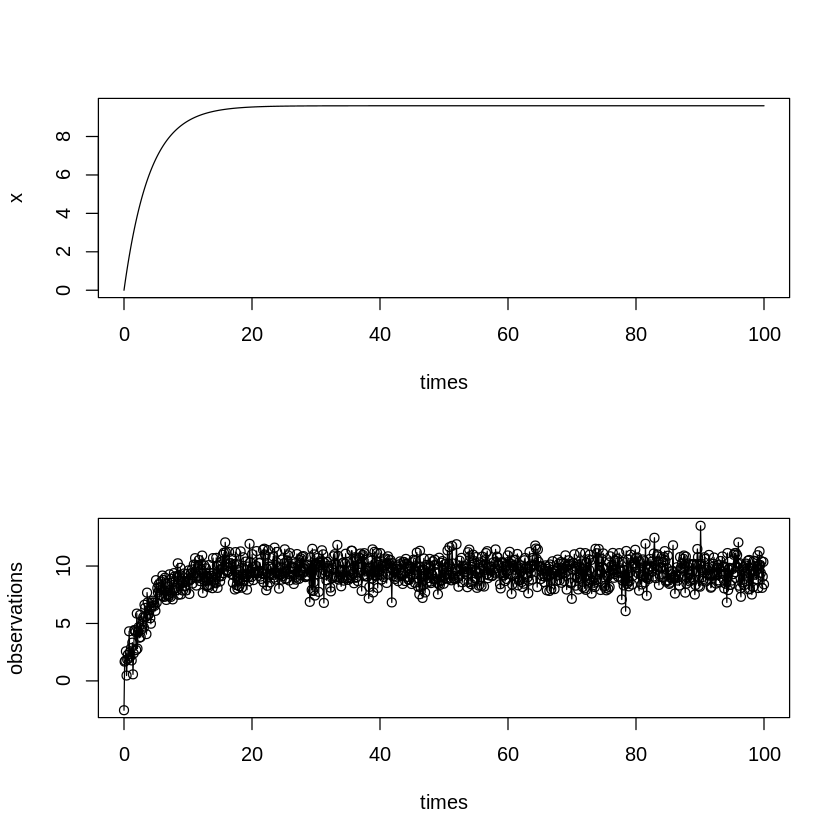

In [ ]:
# Let's simulate the reaction

# solution to first-order kinetics

NSample = 1000 # sample size
sigma <- 1 # observation noise

# parametrize by kon and koff

kon <- 2.4
koff <- 0.25


tStart <- 0
tStop <- 100
times <- seq(from=tStart,to=tStop,by=(tStop-tStart)/(NSample-1))


x <- kon/koff*(1-exp(-koff*times))
soln <- data.frame( "x"=x, "times"=times)

# add noise
y <- x + rnorm(NSample,0,sigma)
soln$observations = y

par(mfrow = c(2,1))

plot(x~times,data=soln,type='l')
plot(observations~times,data=soln,type='o')

## Markov Chain Monte Carlo

We write from scratch an MCMC Metropolis-Hastings implementation. Note there are existing packages that do this, including STAN and ``mcmc``.

In [ ]:
# define the likelihood function

logLikelihood <- function(param,times,y){
    kon = param[1]
    koff = param[2]
    sigma = param[3]
    
    pred = kon/koff*(1-exp(-koff*times))

    singleLikelihoods = dnorm(y, mean=pred, sd=sigma, log=T) # really the log likelihood
    sumLikelihood = sum(singleLikelihoods) # really the log of the product of likelihoods
        
    return(sumLikelihood)
    
}

# Test it out
logLikelihood(c(2.3, 0.25, 0.1),times,y)
logLikelihood(c(2.5, 0.25, 0.1),times,y)

[1] -55658.53

[1] -52726.7

In [ ]:
# Here is the Metropolis algorithm!

proposalGenerator <- function(currentParam){
    
    proposalParam = rnorm(3, mean=currentParam, sd = c(0.002,0.0002,0.001)) #kon,koff 
    # play with these to make the acceptance rates around 30% for most efficient MCMC
    proposalParam[proposalParam<0] <- 0 # Prevent negative values
    return(proposalParam)
}

run_metropolis_MCMC <- function(startvalue, iterations){
    chain = array(dim = c(iterations+1,3))
    chain[1,] = startvalue
    for (i in 1:iterations){
        
        proposal = proposalGenerator(chain[i,])
         
        # This is the Metropolis-Hastings ("Boltzmann") test
        probab = exp(logLikelihood(proposal,times,y) - logLikelihood(chain[i,],times,y))    
        if (runif(1) < probab){
            chain[i+1,] = proposal
        }
        else{
            chain[i+1,] = chain[i,]
        }
    }
    return(chain)
}
 
startvalue = c(1,0.1,0.1)
chain = run_metropolis_MCMC(startvalue, 100000)
 
burnIn = 10000
acceptance = 1-mean(duplicated(chain[-(1:burnIn),]))

1.000000,0.1000000,0.1000000
1.003603,0.1000064,0.1008872
1.001001,0.1001329,0.1010969
1.001001,0.1001329,0.1010969
1.001001,0.1001329,0.1010969
1.001001,0.1001329,0.1010969


[1] 0.8934901


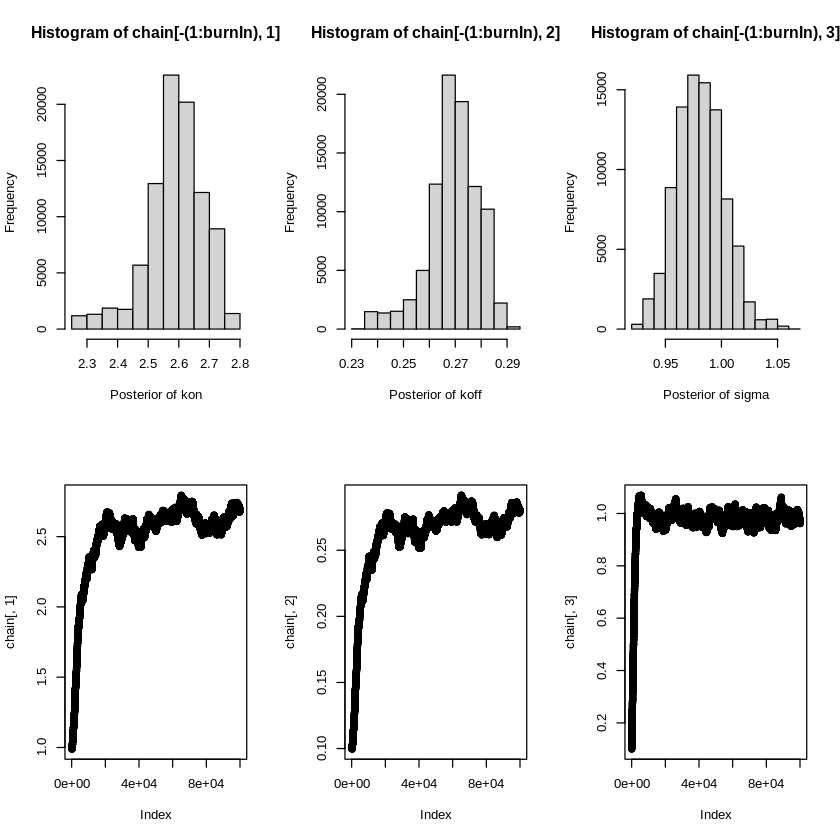

In [ ]:
# Explore the results.

head(chain)
print(acceptance) # Is it close to 30%?

# Conditional posteriors
par(mfrow = c(2,3))

hist(chain[-(1:burnIn),1], xlab="Posterior of kon")
hist(chain[-(1:burnIn),2], xlab="Posterior of koff")
hist(chain[-(1:burnIn),3], xlab="Posterior of sigma")

plot(chain[,1])
plot(chain[,2])
plot(chain[,3])

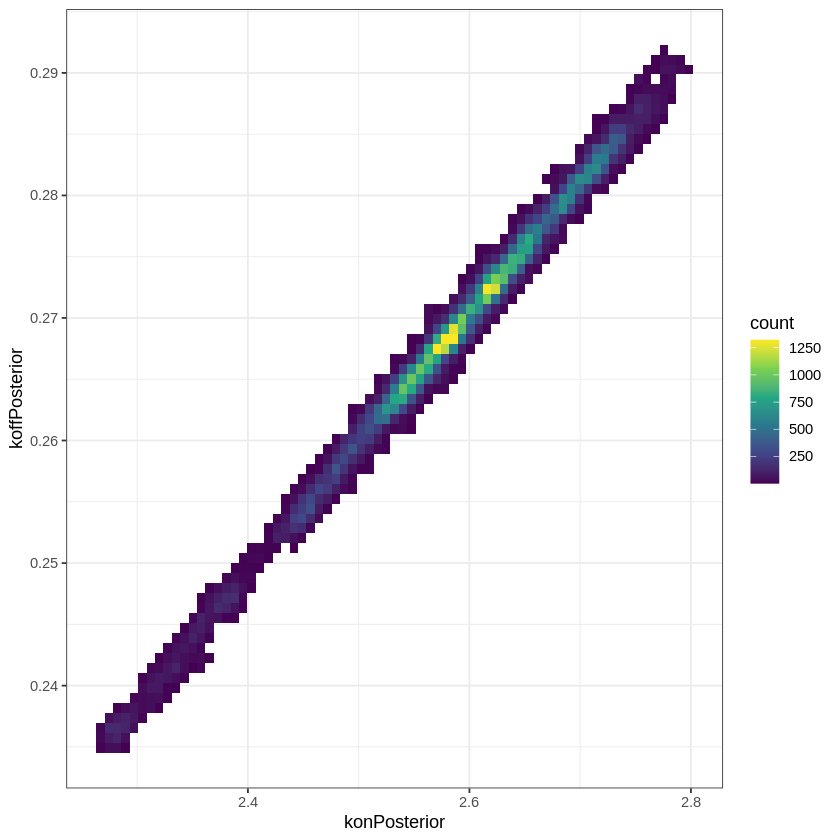

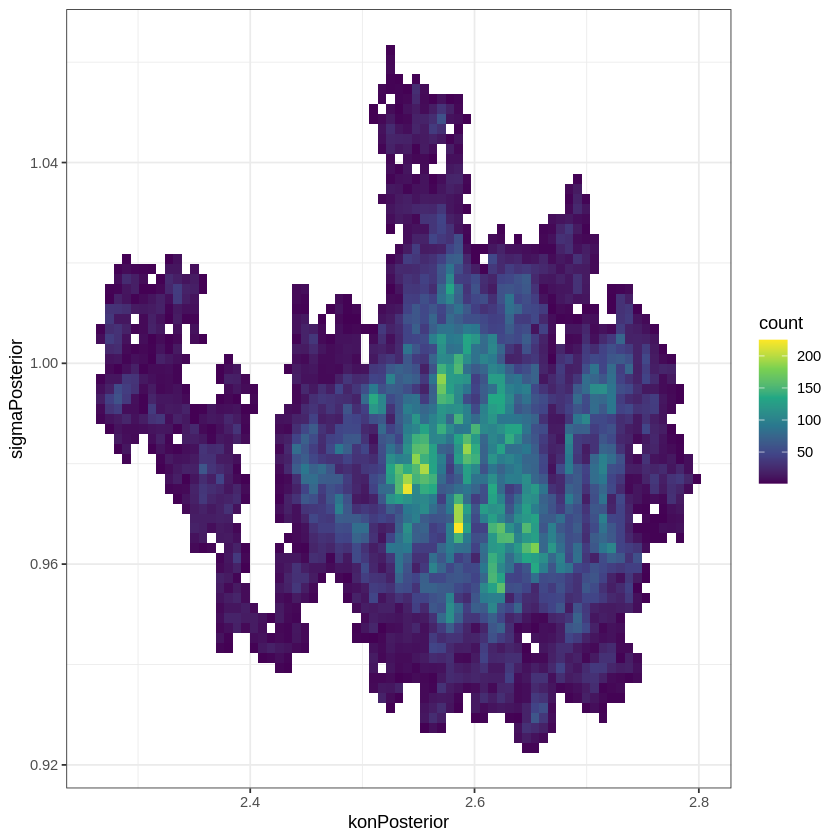

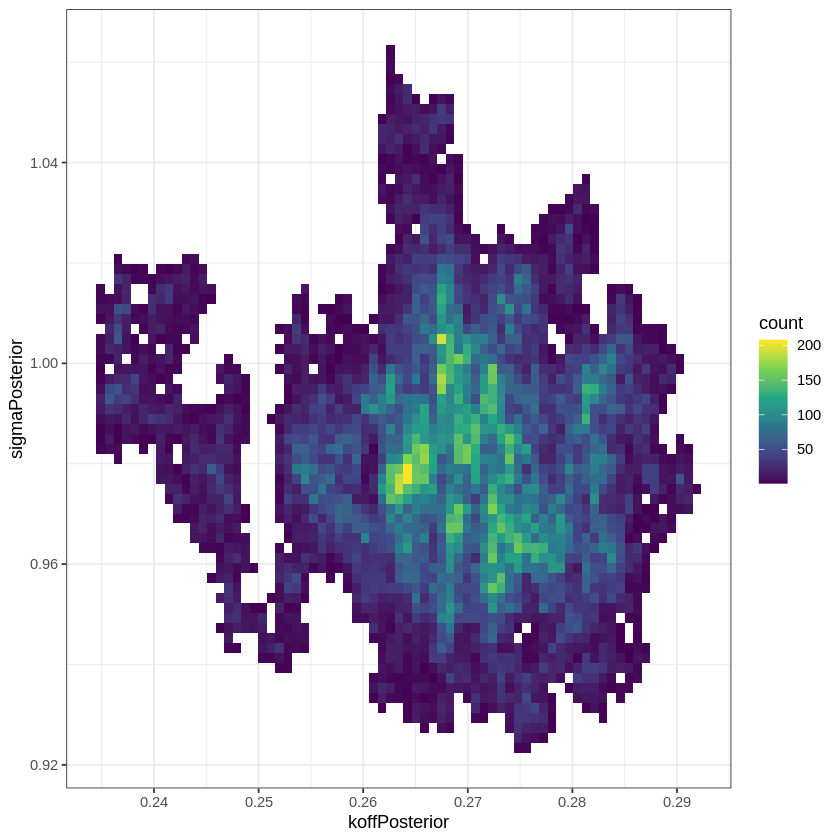

In [ ]:
# joint posterior

dfChain <- data.frame(konPosterior=chain[-(1:burnIn),1], 
                      koffPosterior=chain[-(1:burnIn),2],
                      sigmaPosterior=chain[-(1:burnIn),3] )


ggplot(dfChain, aes(x=konPosterior, y=koffPosterior) ) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()

ggplot(dfChain, aes(x=konPosterior, y=sigmaPosterior) ) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()

ggplot(dfChain, aes(x=koffPosterior, y=sigmaPosterior) ) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()


# Problem set

The chemical reaction we simulated is mathematically identical to 

$$\frac{dx}{dt} = \frac{1}{\tau}\left( K_D -  x \right)$$

where $\tau$ is the timescale of the reaction and $K_D$ is the equilibrium constant. 

In this problem, we will MCMC to fit the simulated data to discover the values of paramaters ``KD``, ``tau`` and ``sigma`` (the same as above, the standard deviation of the observational noise).

To perform MCMC, we must choose priors. We make the simplest assumption and use flat priors, subject to non-negativity (we require KD>0, tau>0 and sigma>0). 

## 1. Change of variables

Show that the chemical reaction with $K_D$ and $\tau$ is identical to the first one with $k_{\rm on}$ and $k_{\rm off}$. What is the relationship between the two sets of parameters?

If we set $K_{on}=\frac{K_D}{\tau}$ and $K_{off}=\frac{1}{\tau}$ we will see that the chemical reaction is the same as the one above.

## 2. Flat priors in KD and Tau

Modify the code above to perform MCMC on the same data, but with $K_D$ and $\tau$ (as well as $\sigma$) as the parameters to infer. 

You may use a separate notebook if that is easier to organize.

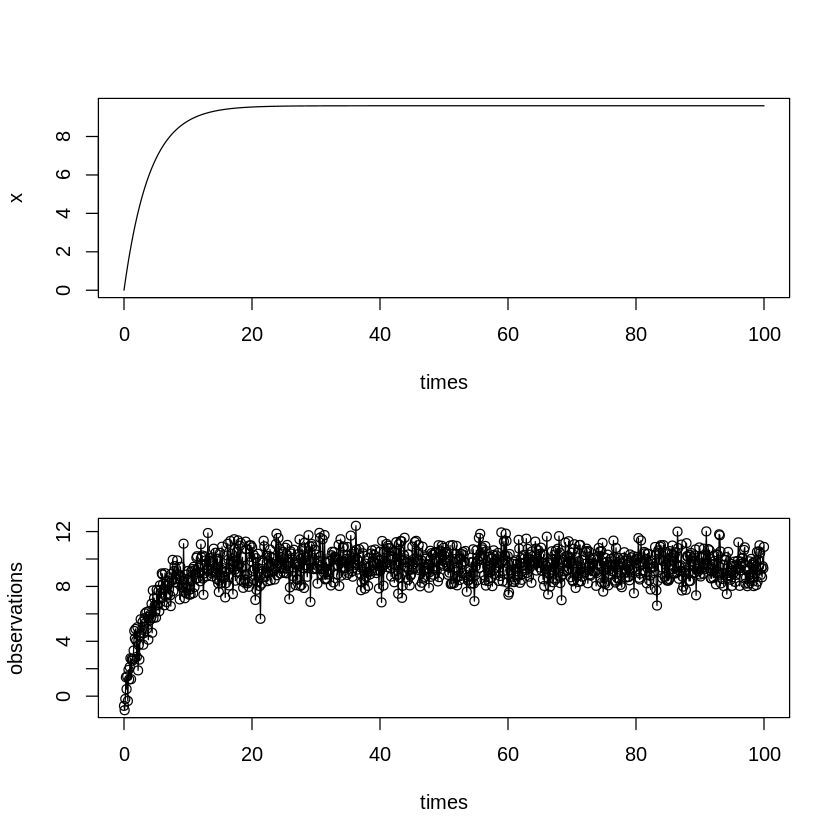

In [2]:
# Let's simulate the reaction

# solution to first-order kinetics

NSample = 1000 # sample size
sigma <- 1 # observation noise

kd <- 9.6
tau <- 4

# parametrize by kon and koff
kon <- kd/tau
koff <- 1/tau

tStart <- 0
tStop <- 100
times <- seq(from=tStart,to=tStop,by=(tStop-tStart)/(NSample-1))


x <- kon/koff*(1-exp(-koff*times))
soln <- data.frame( "x"=x, "times"=times)

# add noise
y <- x + rnorm(NSample,0,sigma)
soln$observations = y

par(mfrow = c(2,1))

plot(x~times,data=soln,type='l')
plot(observations~times,data=soln,type='o')

In [3]:
# define the likelihood function

logLikelihood <- function(param,times,y){
    kd = param[1]
    tau = param[2]
    sigma = param[3]
    
    kon <- kd/tau
    koff <- 1/tau

    pred = kon/koff*(1-exp(-koff*times))

    singleLikelihoods = dnorm(y, mean=pred, sd=sigma, log=T) # really the log likelihood
    sumLikelihood = sum(singleLikelihoods) # really the log of the product of likelihoods
        
    return(sumLikelihood)
    
}

# Test it out
logLikelihood(c(2.3, 0.25, 0.1),times,y)
logLikelihood(c(5, 1, 0.1),times,y)

[1] -2506543

[1] -1001708

In [4]:
# Here is the Metropolis algorithm!

proposalGenerator <- function(currentParam){
    
    proposalParam = rnorm(3, mean=currentParam, sd = c(0.005,0.005,0.0005)) #kon,koff 
    # play with these to make the acceptance rates around 30% for most efficient MCMC
    proposalParam[proposalParam<0] <- 0 # Prevent negative values
    return(proposalParam)
}

run_metropolis_MCMC <- function(startvalue, iterations){
    chain = array(dim = c(iterations+1,3))
    chain[1,] = startvalue
    for (i in 1:iterations){
        
        proposal = proposalGenerator(chain[i,])
         
        # This is the Metropolis-Hastings ("Boltzmann") test
        probab = exp(logLikelihood(proposal,times,y) - logLikelihood(chain[i,],times,y))    
        if (runif(1) < probab){
            chain[i+1,] = proposal
        }
        else{
            chain[i+1,] = chain[i,]
        }
    }
    return(chain)
}
 
startvalue = c(1,1,0.01)
chain = run_metropolis_MCMC(startvalue, 100000)
 
burnIn = 10000
acceptance = 1-mean(duplicated(chain[-(1:burnIn),]))

1.000000,1.0000000,0.01000000
0.999072,0.9952308,0.01024949
0.999072,0.9952308,0.01024949
0.999072,0.9952308,0.01024949
1.000393,0.9945554,0.01034584
1.001805,0.9882669,0.01095433


[1] 0.9476117


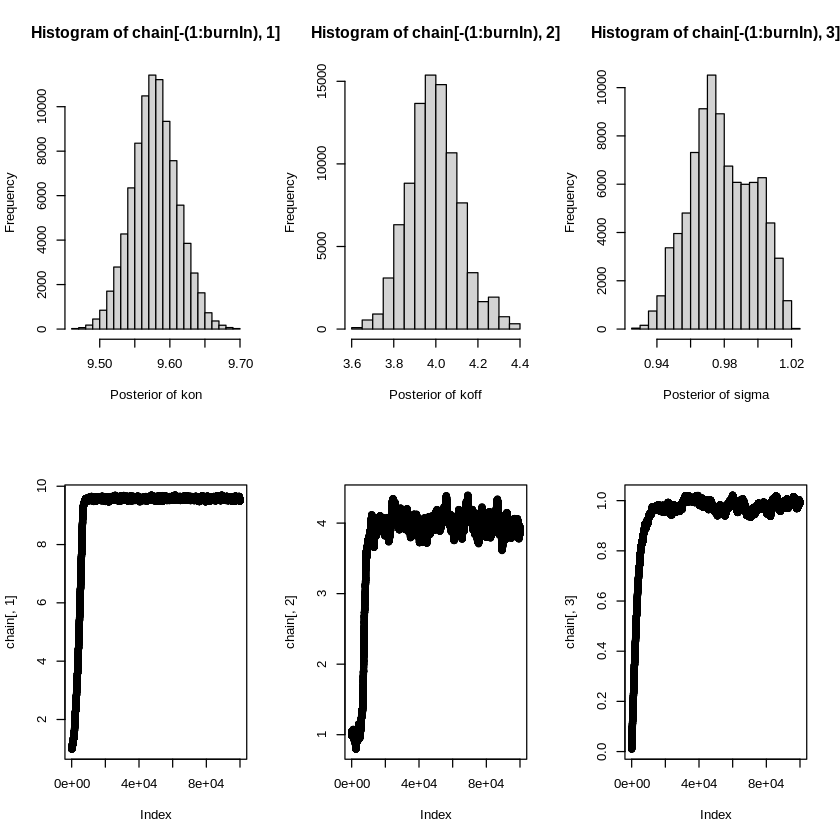

In [5]:
# Explore the results.

head(chain)
print(acceptance) # Is it close to 30%?

# Conditional posteriors
par(mfrow = c(2,3))

hist(chain[-(1:burnIn),1], xlab="Posterior of kon")
hist(chain[-(1:burnIn),2], xlab="Posterior of koff")
hist(chain[-(1:burnIn),3], xlab="Posterior of sigma")

plot(chain[,1])
plot(chain[,2])
plot(chain[,3])

## 3. Comparison

Take the chain representing the posterior (minus the burn-in period) and convert it to $k_{\rm on}$ and $k_{\rm off}$ using the equations you found in Part 1. Plot the joint posterior distributions.

How does this compare to the posteriors of $k_{\rm on}$ and $k_{\rm off}$ that resulted from assuming flat priors in $k_{\rm on}$ and $k_{\rm off}$?

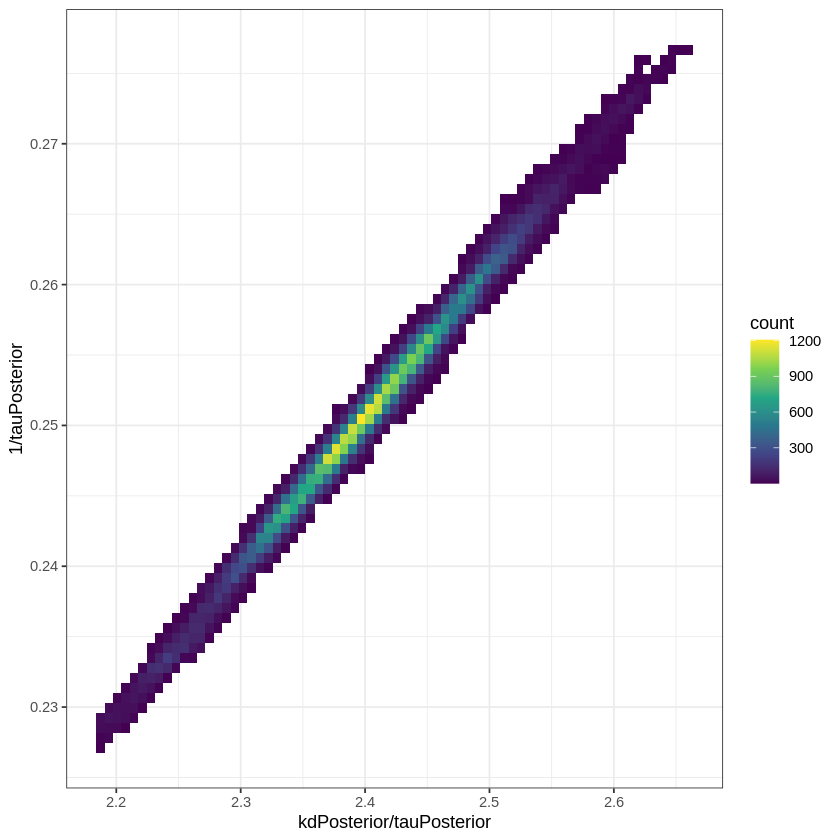

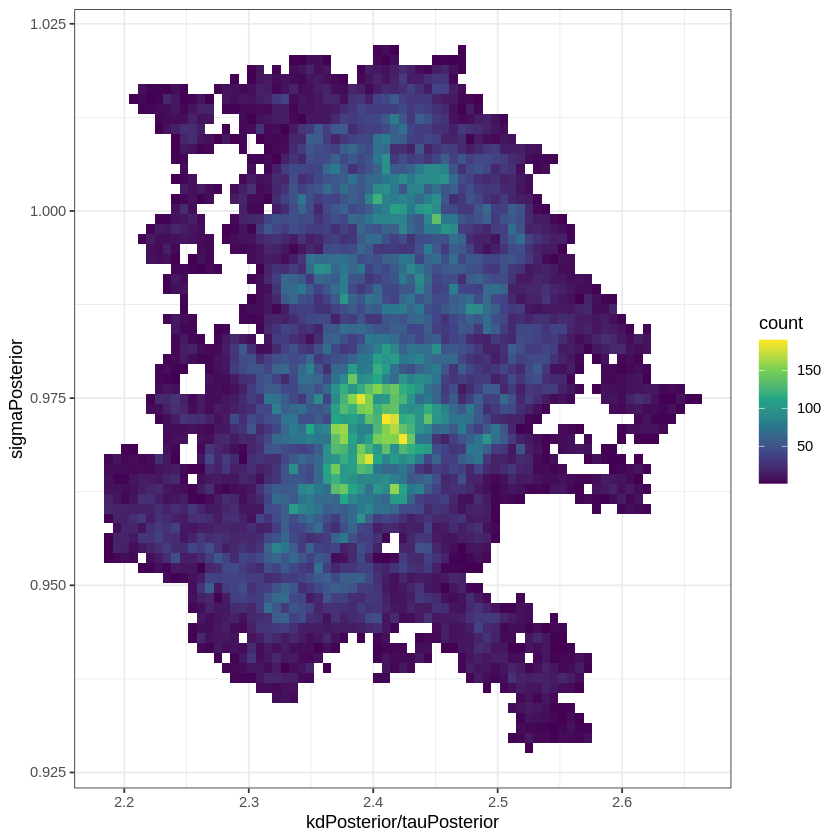

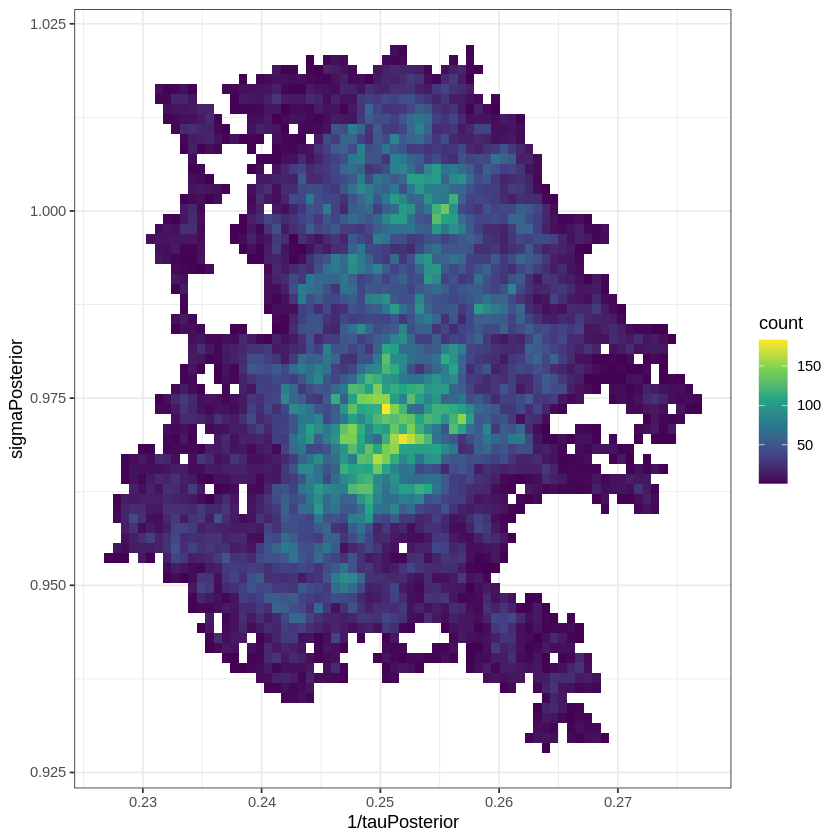

In [12]:
# joint posterior

dfChain <- data.frame(kdPosterior=chain[-(1:burnIn),1], 
                      tauPosterior=chain[-(1:burnIn),2],
                      sigmaPosterior=chain[-(1:burnIn),3] )

#kon vs koff
ggplot(dfChain, aes(x=kdPosterior/tauPosterior, y=1/tauPosterior) ) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()

#kon
ggplot(dfChain, aes(x=kdPosterior/tauPosterior, y=sigmaPosterior) ) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()

#koff
  ggplot(dfChain, aes(x=1/tauPosterior, y=sigmaPosterior) ) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()

When compare to the result with flat priors, the value corresponding to the best parameters changed. 